In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

# Anomaly Detection Project
#### Task:
I have some questions for you that I need to be answered before the board meeting Friday afternoon. I need to be able to speak to the following questions. I also need a single slide that I can incorporate into my existing presentation (Google Slides) that summarizes the most important points. My questions are listed below; however, if you discover anything else important that I didn’t think to ask, please include that as well.

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
7. Which lessons are least accessed?
8. Anything else I should be aware of?

In [2]:
# Read in the data from mysql
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
df = pd.read_sql('''SELECT * FROM logs LEFT JOIN cohorts ON cohorts.id = logs.cohort_id;''', url)

In [3]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [4]:
df_copy = df.copy()

#### Cleaning Path Columns

In [5]:
df = df[~df.path.str.endswith('jpg',na=False)]
df = df[~df.path.str.endswith('jpeg',na=False)]
df = df[~df.path.str.endswith('svg',na=False)]
df = df[(df.path != '/') & (df.path != 'search/search_index.json')]

### Creating separate columns for each portion of the 'path'...not sure what to call them yet

In [6]:
df['path_1'] = df.path.str.split('/').str[0]
df['path_2'] = df.path.str.split('/').str[1]
df['path_3'] = df.path.str.split('/').str[2]
df['path_4'] = df.path.str.split('/').str[3]

In [7]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,NaN,NaN,NaN
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,object-oriented-programming,NaN,NaN
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,slides,object_oriented_programming,NaN,NaN
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,conditionals,NaN,NaN
5,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,loops,NaN,NaN


#### Create a date and time column

In [8]:
df['date'] = df['date'].str.cat(df['time'],sep=" ")

In [9]:
df.date = pd.to_datetime(df.date)

##### Set and sort the index

In [10]:
df.set_index(df.date, inplace = True)

In [11]:
df.sort_index()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,path_1,path_2,path_3,path_4
date,,,,,,,,,,,,,,,,,,,
2018-01-26 09:56:02,2018-01-26 09:56:02,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,NaN,NaN,NaN
2018-01-26 09:56:05,2018-01-26 09:56:05,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,java-ii,object-oriented-programming,NaN,NaN
2018-01-26 09:56:06,2018-01-26 09:56:06,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,slides,object_oriented_programming,NaN,NaN
2018-01-26 09:56:24,2018-01-26 09:56:24,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,conditionals,NaN,NaN
2018-01-26 09:56:41,2018-01-26 09:56:41,09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,javascript-i,loops,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,2021-04-21 16:41:51,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,jquery,personal-site,NaN,NaN
2021-04-21 16:42:02,2021-04-21 16:42:02,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,jquery,mapbox-api,NaN,NaN
2021-04-21 16:42:09,2021-04-21 16:42:09,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,28.0,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2.0,jquery,ajax,weather-map,NaN


In [12]:
df.drop(columns=['date','time'], inplace=True)

#### Replace program id values

In [13]:
df.program_id.value_counts()

2.0    657581
3.0     79614
1.0     28708
4.0         4
Name: program_id, dtype: int64

In [14]:
df.program_id.replace([1.0,2.0,3.0,4.0], ['php','java','ds','fe'], inplace=True)

#### This tells us user_id's can have multiple ip's

In [15]:
len(df.user_id.unique())

969

In [16]:
len(df.ip.unique())

5234

#### rename id to cohort_id

In [17]:
df.rename(columns={'id':'cohort_id'}, inplace=True)

#### drop slack column

In [18]:
df.name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', None, 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Hyperion',
       'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna', 'Easley', 'Marco',
       'Florence', 'Neptune', 'Oberon'], dtype=object)

In [19]:
df.slack.unique()

array(['#hampton', '#teddy', '#sequoia', '#arches', '#niagara',
       '#pinnacles', '#quincy', None, '#kings', '#lassen', '#mammoth',
       '#glacier', '#denali', '#joshua', '#olympic', '#ulysses',
       '#badlands', '#apollo', '#ike', '#voyageurs', '#wrangell',
       '#xanadu', '#franklin', '#yosemite', '#', '#zion', '#andromeda',
       '#betelgeuse', '#ceres', '#deimos', '#europa', '#fortuna',
       '#curie', '#apex', '#ganymede', '#hyperion', '#darden', '#bash',
       '#jupiter', '#kalypso', '#luna', '#easley', '#marco', '#florence',
       '#neptune', '#oberon'], dtype=object)

In [20]:
# Drop slack column
df.drop(columns='slack',inplace=True)

In [21]:
# Drop this column
df.deleted_at.value_counts()

Series([], Name: deleted_at, dtype: int64)

In [22]:
df.drop(columns='deleted_at',inplace=True)

#### All of these columns are unique to each cohort

In [23]:
len(df.start_date) == len(df.name)

True

In [24]:
len(df.created_at) == len(df.name)

True

In [25]:
len(df.updated_at) == len(df.name)

True

#### Create hour column

In [26]:
df['hour'] = df.index.hour

In [27]:
df.head()

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,java-ii,NaN,NaN,NaN,9
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,java-ii,object-oriented-programming,NaN,NaN,9
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,slides,object_oriented_programming,NaN,NaN,9
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,conditionals,NaN,NaN,9
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,loops,NaN,NaN,9


In [28]:
df.hour.value_counts()

9     117195
11     85951
14     81174
10     80962
15     74675
13     66975
16     60321
12     44632
8      43031
17     21423
21     21362
20     20874
19     17968
22     17742
18     17163
23     12081
7       9839
0       5999
6       3822
1       3181
5       1787
2       1700
4       1040
3        987
Name: hour, dtype: int64

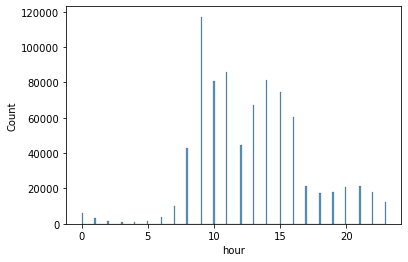

In [29]:
sns.histplot(df.hour)
plt.show()

In [30]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

#### checking out the ip column

In [31]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df

,count,proba
97.105.19.58,262430,0.323236
97.105.19.61,58736,0.072345
192.171.117.210,8805,0.010845
71.150.217.33,6216,0.007656
12.106.208.194,4051,0.004990
...,...,...
172.58.102.191,1,0.000001
107.77.218.153,1,0.000001
185.247.70.76,1,0.000001
172.58.107.225,1,0.000001


<AxesSubplot:>

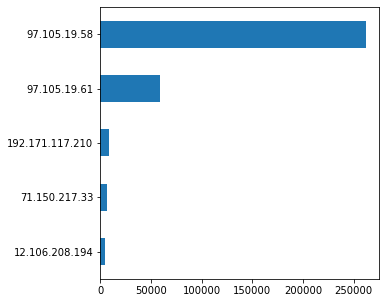

In [32]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

#### Exploring the front end developer...pretty sure it's an anomaly or they decided to rename this program id

In [33]:
df.program_id.value_counts()

java    657581
ds       79614
php      28708
fe           4
Name: program_id, dtype: int64

In [34]:
df[df.program_id=='fe']

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2018-03-22 19:01:54,content/html-css,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,content,html-css,NaN,NaN,19
2018-03-22 19:01:54,content/html-css/gitbook/images/favicon.ico,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,content,html-css,gitbook,images,19
2018-03-22 19:02:47,content/html-css,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,content,html-css,NaN,NaN,19
2018-03-22 19:02:52,content/html-css/introduction.html,152,9.0,207.68.209.17,9.0,Apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,fe,content,html-css,introduction.html,NaN,19


Only 4 rows, all of which were accesed in one day and within a couple of minutes

#### Creating Java DF

In [35]:
java_df = df[df.program_id=='java']

#### Creating PHP DF

In [36]:
php_df = df[df.program_id=='php']

In [37]:
php_df.name.value_counts()

Lassen      9425
Arches      8217
Olympic     4684
Kings       2620
Hampton     1487
Quincy      1073
Glacier      529
Joshua       294
Ike          233
Badlands      76
Franklin      67
Denali         3
Name: name, dtype: int64

#### Exploring Java students path

In [38]:
java_path_df = value_counts_and_frequencies(java_df.path_1)
java_path_df

,count,proba
javascript-i,110118,0.167459
html-css,79001,0.120139
mysql,77340,0.117613
jquery,56787,0.086357
spring,53149,0.080825
...,...,...
PreWork,1,0.000002
extra,1,0.000002
one,1,0.000002
7_kmeans_by_hand,1,0.000002


<AxesSubplot:>

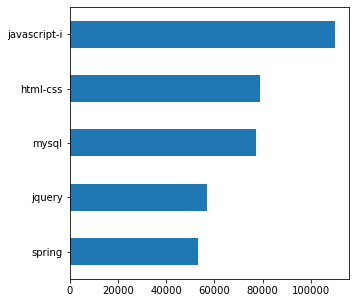

In [39]:
java_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

#### Exploring PHP student path

In [40]:
php_path_df = value_counts_and_frequencies(php_df.path_1)
php_path_df

,count,proba
content,6397,0.222830
javascript-i,3708,0.129163
html-css,2463,0.085795
spring,2324,0.080953
mysql,2067,0.072001
...,...,...
11._DistributedML.md,1,0.000035
4.1_introduction,1,0.000035
6-regression,1,0.000035
Intro_to_Regression,1,0.000035


<AxesSubplot:>

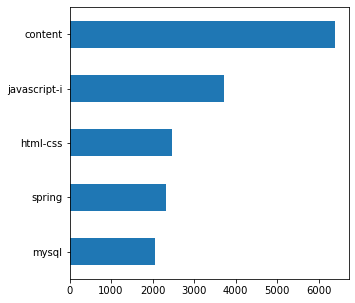

In [41]:
php_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

#### Create DS df

In [42]:
ds_df = df[df.program_id=='ds']

In [43]:
ds_path_df = value_counts_and_frequencies(ds_df.path_1)

<AxesSubplot:>

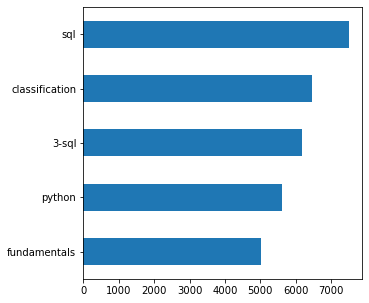

In [44]:
ds_path_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 5))

In [45]:
df.head()

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,java-ii,NaN,NaN,NaN,9
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,java-ii,object-oriented-programming,NaN,NaN,9
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,php,slides,object_oriented_programming,NaN,NaN,9
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,conditionals,NaN,NaN,9
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,22.0,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,java,javascript-i,loops,NaN,NaN,9


### Making CSV's

In [46]:
df.to_csv('anomaly_project.csv')

In [47]:
ds_df.to_csv('data_science.csv')

In [48]:
java_df.to_csv('java.csv')

In [49]:
php_df.to_csv('php.csv')

In [50]:
fe_df = df[df.program_id == 'fe']

In [51]:
fe_df.to_csv('fe.csv')

In [52]:
non_ds_df = df[df.program_id != 'ds']

In [53]:
non_ds_df.to_csv('non_data_students.csv')

In [54]:
ds_df.path.value_counts().sort_values()

7-classification/svm                           1
12-distributed-ml/6.4-prepare-part-4           1
sql                                            1
storytelling/creating-custom-fields.md         1
decision-trees                                 1
                                            ... 
6-regression/1-overview                     1124
fundamentals/intro-to-data-science          1413
sql/mysql-overview                          1424
1-fundamentals/1.1-intro-to-data-science    1633
classification/overview                     1785
Name: path, Length: 634, dtype: int64

## 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [130]:
php_df.path.value_counts()

index.html                                                     1011
javascript-i                                                    736
html-css                                                        542
spring                                                          501
java-iii                                                        479
                                                               ... 
interview-questions                                               1
content/examples/javascript/primitive-types.html                  1
11._DistributedML                                                 1
content/appendix/javascript/javascript/functions/scope.html       1
content/appendix/javascript/functions/controllers.html            1
Name: path, Length: 696, dtype: int64

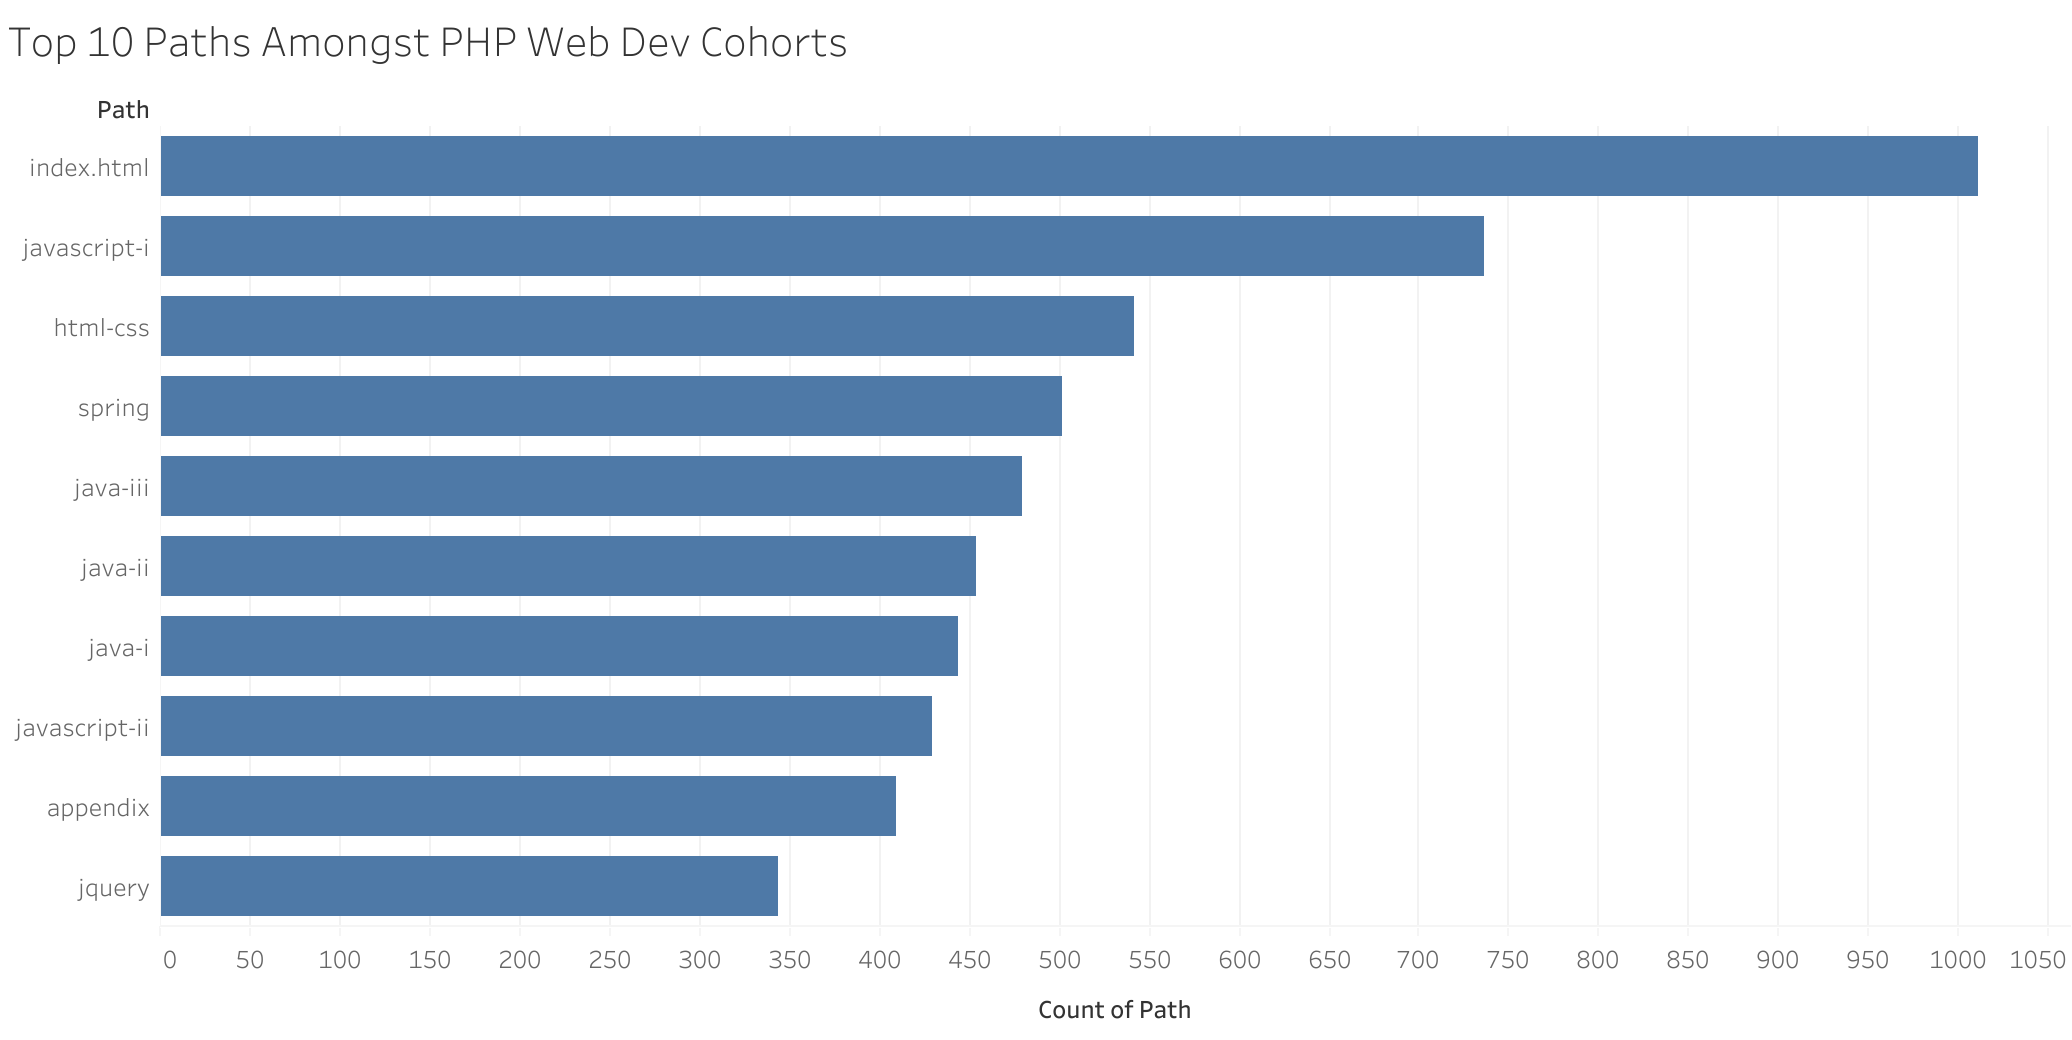

In [131]:
java_df.path.value_counts()

javascript-i                                  17457
toc                                           17428
java-iii                                      12683
html-css                                      12569
java-ii                                       11719
                                              ...  
curie-python-assessment                           1
content/jquery/events/keyboard-events.html        1
appendix/interview_questions_instructors          1
SVM_NLP                                           1
content/appendix/postwork/sales-tax.html          1
Name: path, Length: 1863, dtype: int64

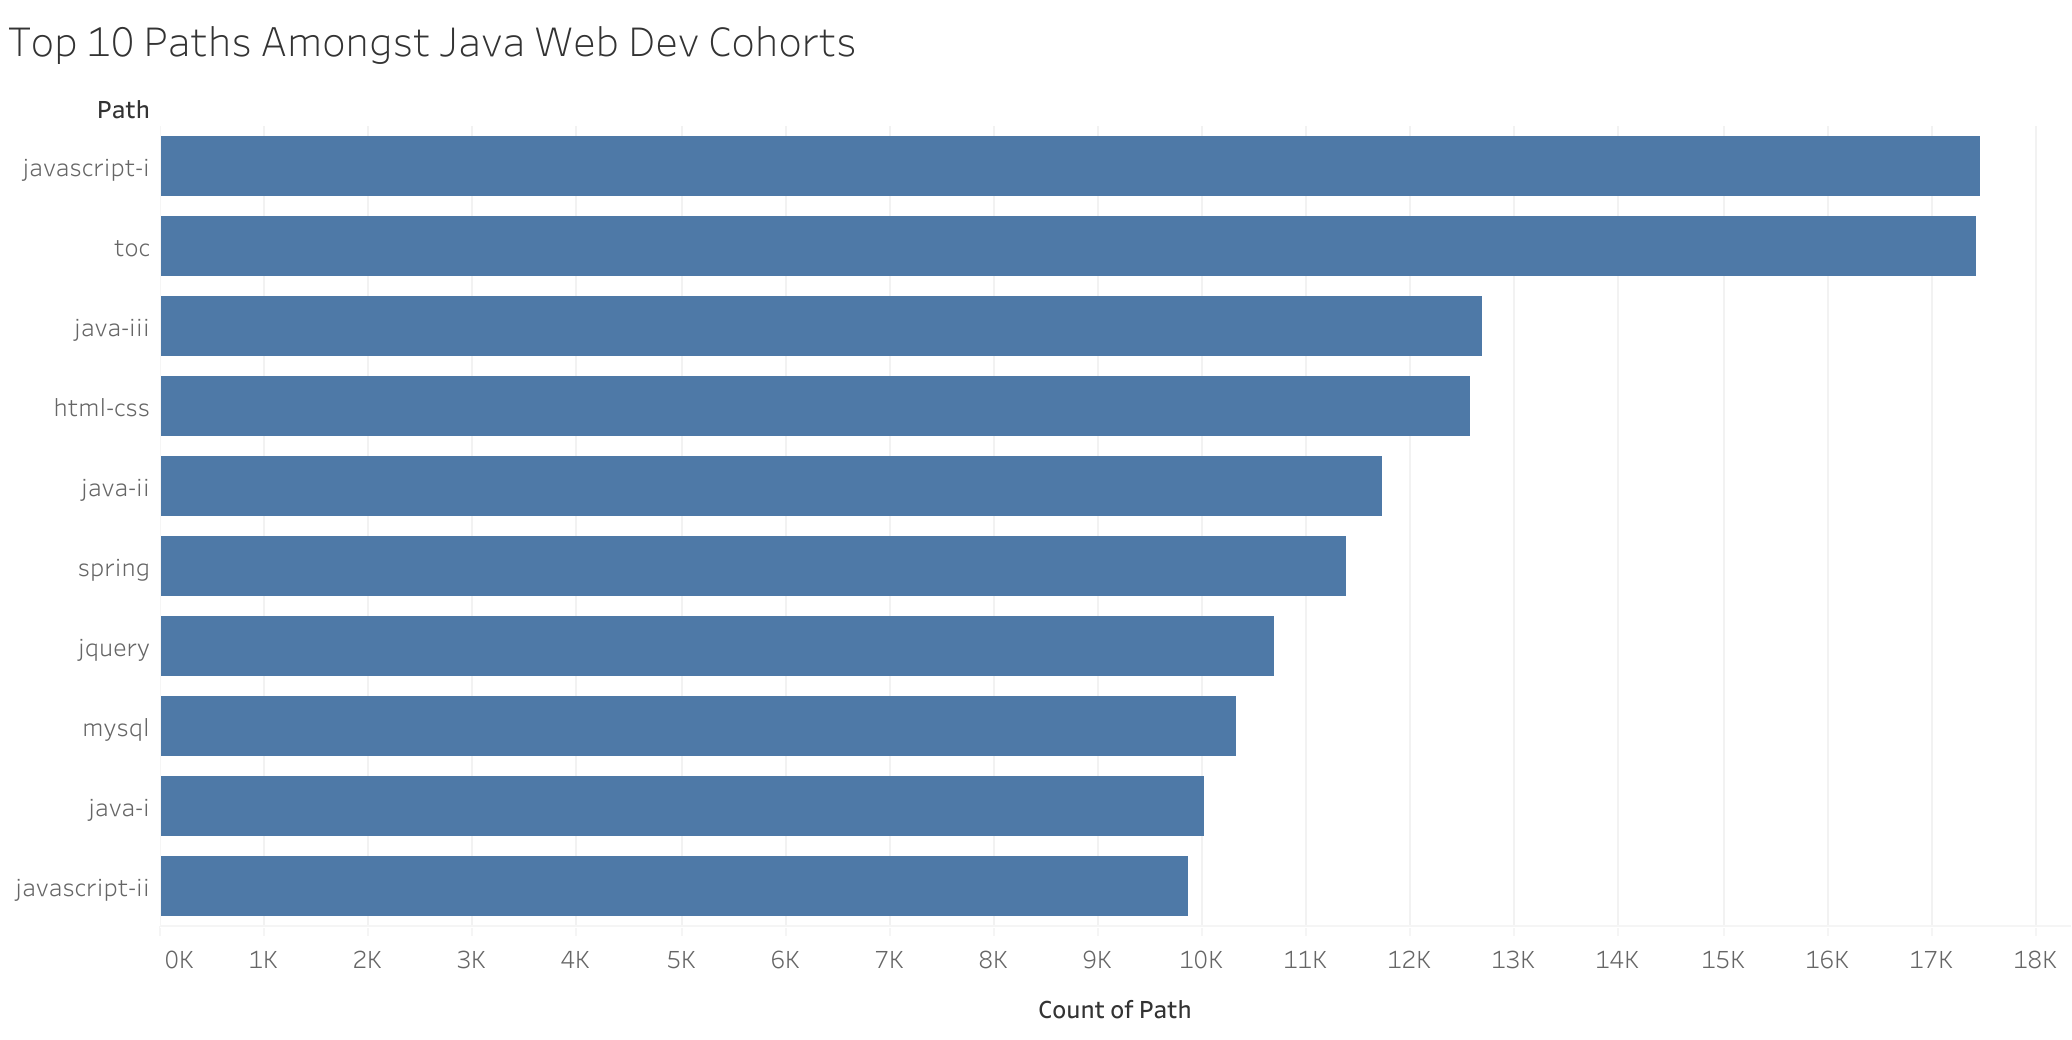

In [129]:
ds_df.path.value_counts()

classification/overview                          1785
1-fundamentals/1.1-intro-to-data-science         1633
sql/mysql-overview                               1424
fundamentals/intro-to-data-science               1413
6-regression/1-overview                          1124
                                                 ... 
spring/extra-features/error-pages/asdfasdf          1
mkdocs/search_index.json                            1
fundamentals/cli/navigating-the-filesystem.md       1
group-by                                            1
7-classification/svm                                1
Name: path, Length: 634, dtype: int64

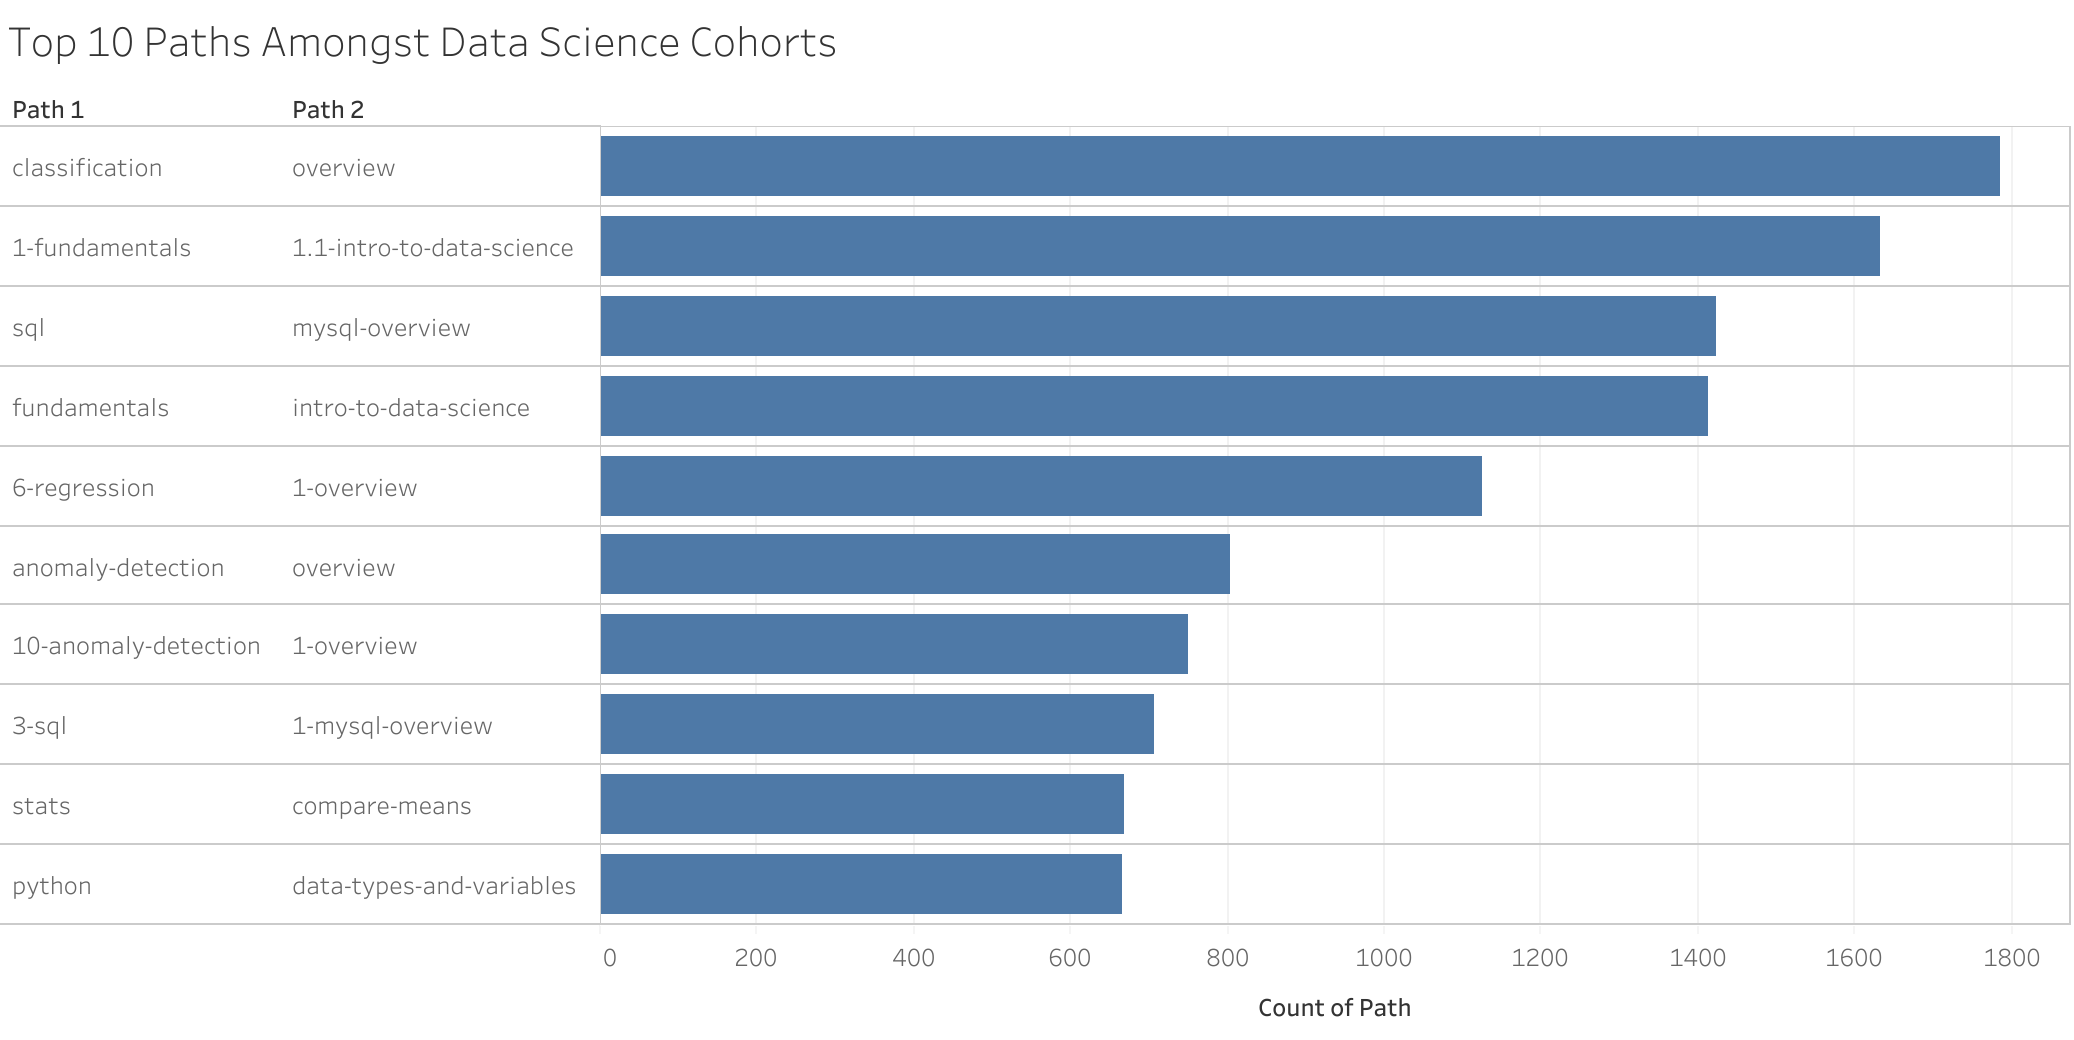

## 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

For Data Science:

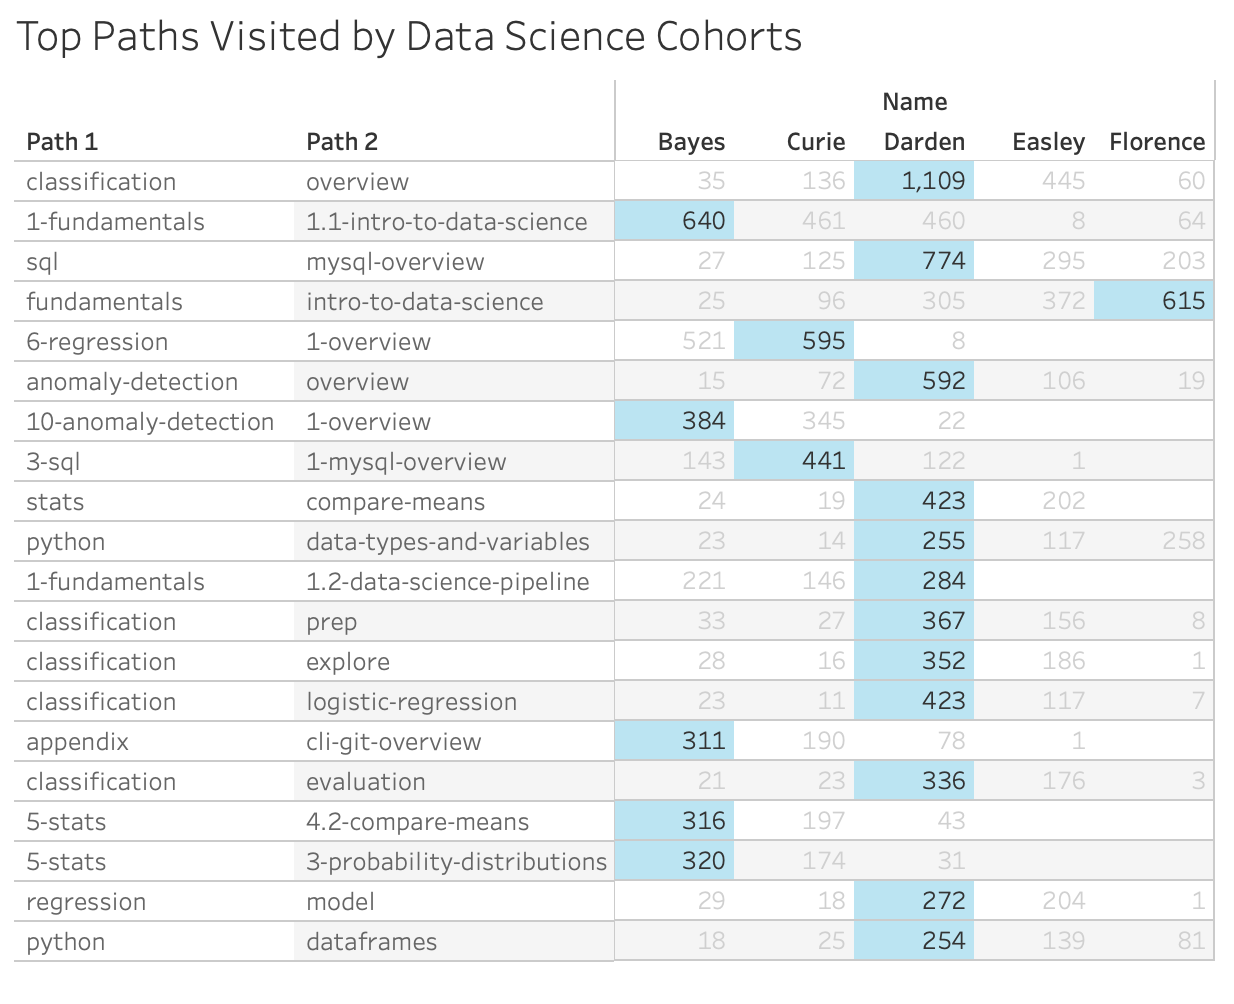

### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [55]:
# Creating a DF for all post grad DS students
ds_grads = ds_df[ds_df.index > ds_df.end_date]

In [57]:
ds_grads.name

date
2020-01-30 08:01:31     Bayes
2020-01-31 11:05:13     Bayes
2020-01-31 14:47:20     Bayes
2020-01-31 14:47:26     Bayes
2020-01-31 14:47:27     Bayes
                        ...  
2021-04-21 13:17:05    Darden
2021-04-21 13:17:07    Darden
2021-04-21 15:20:12    Darden
2021-04-21 15:20:14    Darden
2021-04-21 15:20:18    Darden
Name: name, Length: 8108, dtype: object

In [58]:
ds_grads.path.value_counts().head(10)

sql/mysql-overview                          275
classification/overview                     267
anomaly-detection/overview                  191
fundamentals/intro-to-data-science          184
1-fundamentals/1.1-intro-to-data-science    127
sql/database-design                          87
6-regression/1-overview                      86
classification/prep                          77
fundamentals/environment-setup               76
stats/compare-means                          73
Name: path, dtype: int64

In [59]:
# Creating a DF for non Data Science grads
non_ds_grads = non_ds_df[non_ds_df.index > non_ds_df.end_date]

In [60]:
non_ds_grads.path.value_counts().head(10)

javascript-i     4969
spring           4272
html-css         3687
java-iii         3541
java-ii          3444
java-i           3130
appendix         3086
javascript-ii    2981
mysql            2584
toc              2574
Name: path, dtype: int64

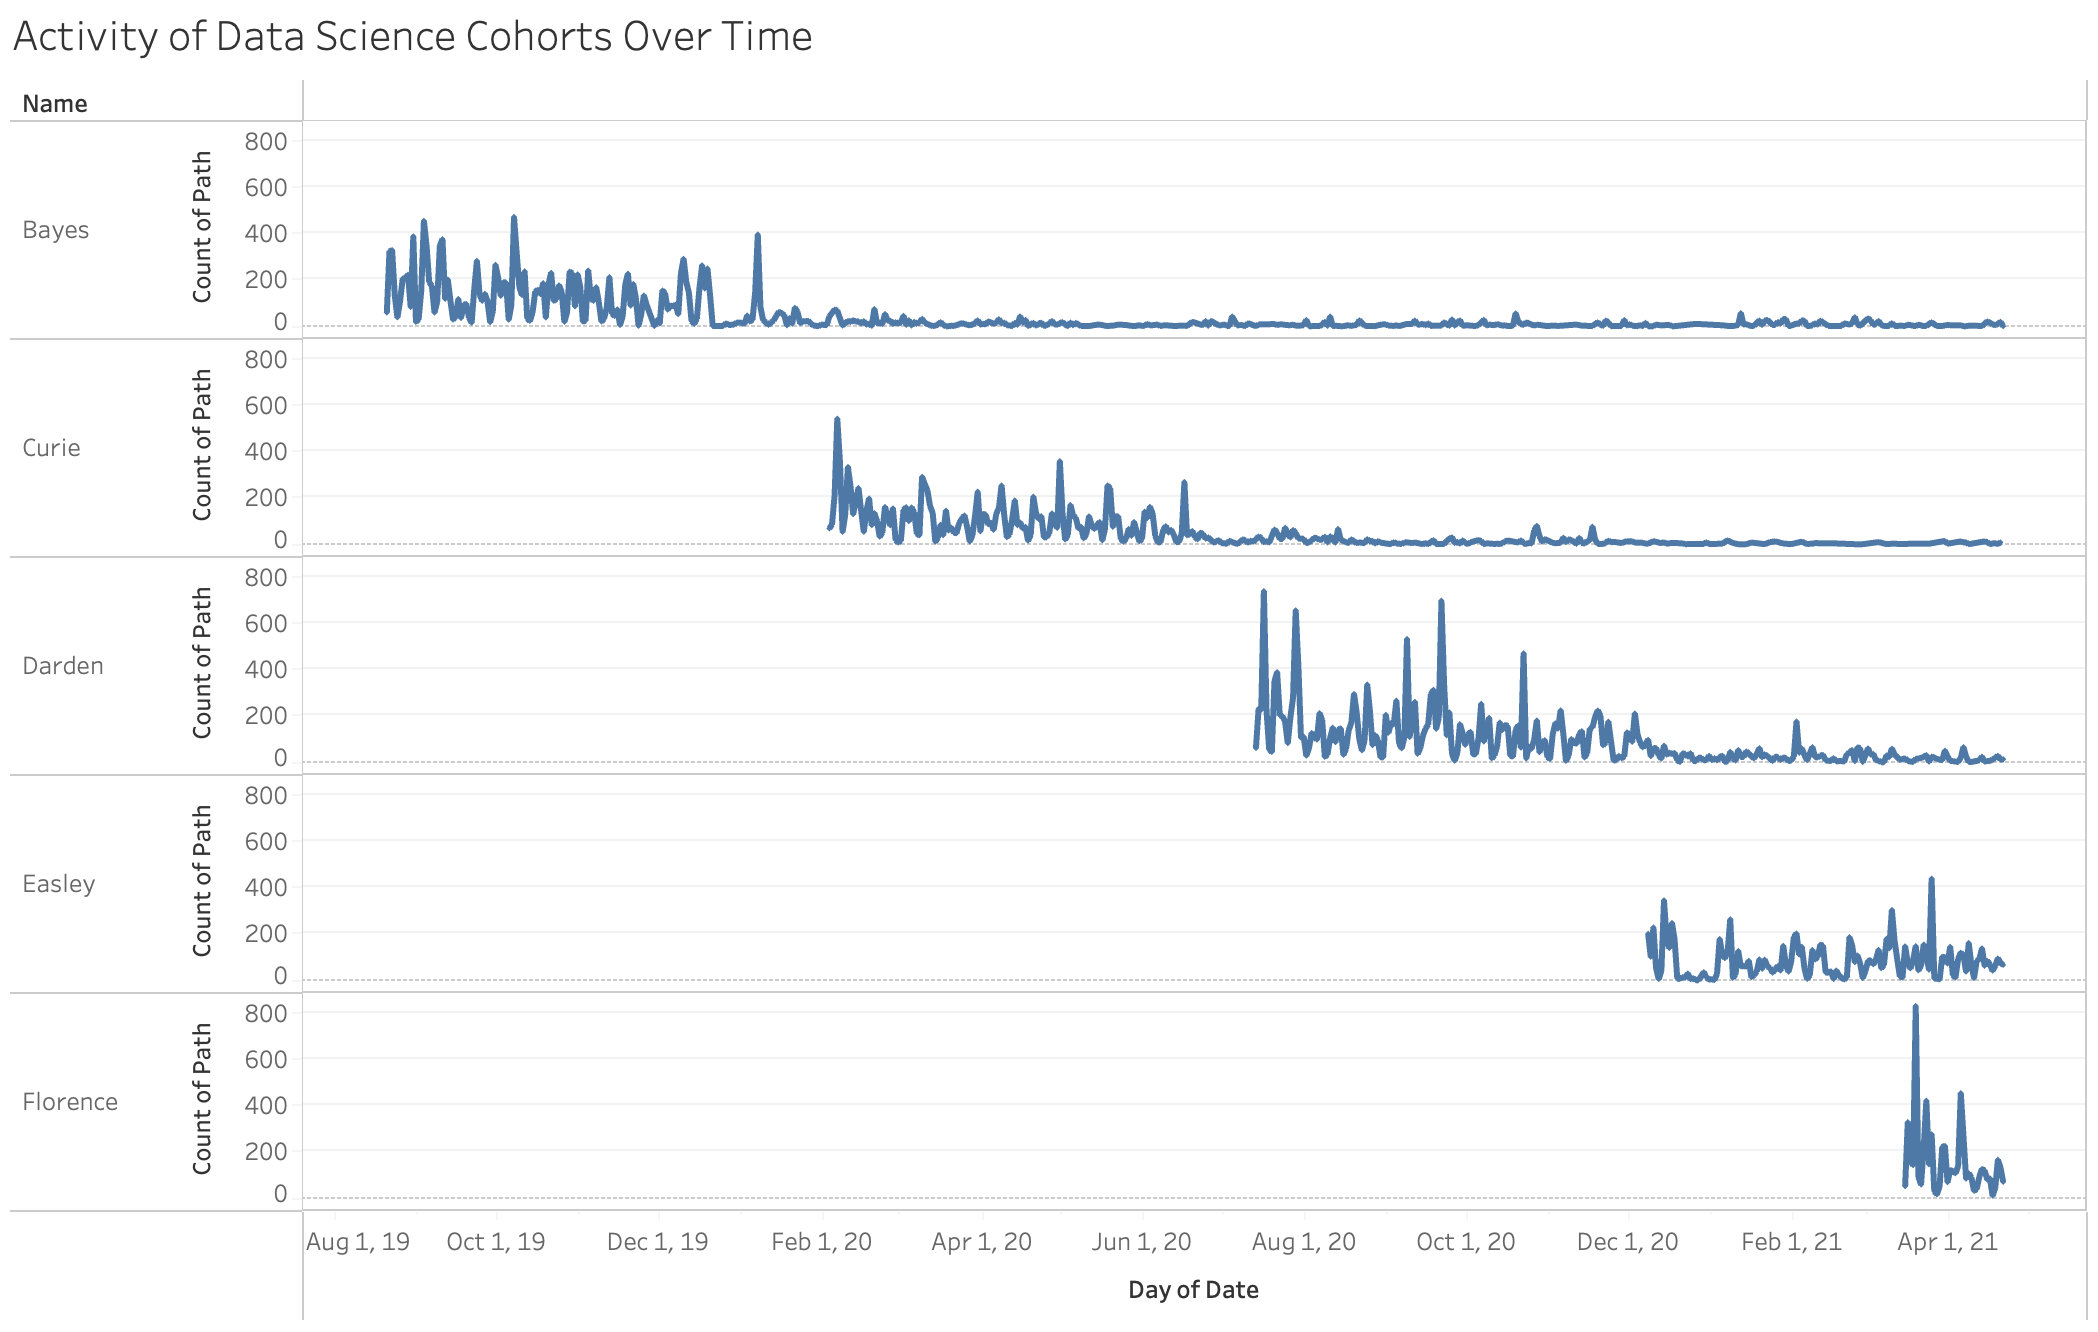

## Which lessons are least accessed?

In [91]:
# I think these are popping up because the title of the lessons 
# were re formatted(ex: 7-classification, vs classification)
ds_df.path.value_counts().sort_values()

7-classification/svm                           1
12-distributed-ml/6.4-prepare-part-4           1
sql                                            1
storytelling/creating-custom-fields.md         1
decision-trees                                 1
                                            ... 
6-regression/1-overview                     1124
fundamentals/intro-to-data-science          1413
sql/mysql-overview                          1424
1-fundamentals/1.1-intro-to-data-science    1633
classification/overview                     1785
Name: path, Length: 634, dtype: int64

In [114]:
counts = ds_df.path.value_counts()
counts

classification/overview                          1785
1-fundamentals/1.1-intro-to-data-science         1633
sql/mysql-overview                               1424
fundamentals/intro-to-data-science               1413
6-regression/1-overview                          1124
                                                 ... 
spring/extra-features/error-pages/asdfasdf          1
mkdocs/search_index.json                            1
fundamentals/cli/navigating-the-filesystem.md       1
group-by                                            1
7-classification/svm                                1
Name: path, Length: 634, dtype: int64

In [116]:
# Setting a threshold to 50 at least 50 requests yet under 100
counts[(counts < 100) & (counts > 50)].sort_values().head(10)

advanced-topics/cross-validation                       51
storytelling/creating-stories                          52
anomaly-detection/detecting-with-clustering            53
appendix/data-viz-references                           57
appendix/professional-development/t-block-lesson-ds    58
4-python/7.1-ds-libraries-overview                     59
6-regression/6-feature-engineering                     60
capstones/capstones                                    62
5-stats/5-power-analysis                               63
2-storytelling/3.3-creating-charts                     67
Name: path, dtype: int64

In [77]:
non_ds_df.path.value_counts().sort_values()

11-nlp/3-acquire/.json                       1
slides/exceptions_and_error_handlings        1
content/javascript-with-html.html            1
interview                                    1
users/167                                    1
                                         ...  
java-ii                                  12681
html-css                                 13619
java-iii                                 13729
toc                                      18286
javascript-i                             18973
Name: path, Length: 2100, dtype: int64

In [120]:
counts = non_ds_df.path.value_counts()
counts

javascript-i              18973
toc                       18286
java-iii                  13729
html-css                  13619
java-ii                   12681
                          ...  
users/913                     1
cohorts/27/quizzes            1
capstone/54                   1
examples/html/welcome         1
11-nlp/3-acquire/.json        1
Name: path, Length: 2100, dtype: int64

In [127]:
counts[(counts < 100) & (counts > 50)].sort_values().head(15)

open_data                                                                 51
content/javascript/javascript-with-html.html                              51
appendix/postwork                                                         51
examples/html/SpecRunner.html                                             51
6-regression/8.0-Project                                                  52
content/php_i/intro-via-interactive-shell/doing-math-in-the-shell.html    52
12-distributed-ml/1-overview                                              52
content/mysql/intro-to-mysql/gitbook/images/favicon.ico                   52
01_intro                                                                  53
4-python/7.4.2-series                                                     53
appendix/coding-challenges/intermediate                                   53
5-stats/4.3-correlation                                                   53
classification/random-forests                                             53

In [123]:
df[df.path=='12-distributed-ml/1-overview'].program_id.value_counts()

ds      89
java    31
Name: program_id, dtype: int64

In [124]:
java_df[java_df.path=='12-distributed-ml/1-overview']

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2019-08-12 09:15:53,12-distributed-ml/1-overview,11,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,9
2019-08-12 10:31:33,12-distributed-ml/1-overview,11,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,10
2019-08-12 11:42:32,12-distributed-ml/1-overview,11,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,11
2019-08-12 13:33:22,12-distributed-ml/1-overview,11,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,13
2019-08-14 14:26:50,12-distributed-ml/1-overview,11,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,14
2019-09-09 16:31:37,12-distributed-ml/1-overview,404,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,16
2019-10-05 10:45:52,12-distributed-ml/1-overview,11,28.0,76.185.131.226,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,10
2019-10-15 14:26:26,12-distributed-ml/1-overview,1,28.0,97.105.19.58,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,14
2019-10-18 11:00:13,12-distributed-ml/1-overview,146,28.0,12.106.208.194,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,12-distributed-ml,1-overview,NaN,NaN,11


Realizing some of these are from Staff

### 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [99]:
df.ip.index.value_counts()

2019-03-03 22:52:09    30
2019-03-03 22:52:07    30
2019-03-03 22:52:11    25
2019-03-03 22:52:08    25
2019-03-03 22:52:10    25
                       ..
2020-09-26 23:12:44     1
2020-04-13 10:26:40     1
2019-09-09 10:25:41     1
2020-11-19 11:05:44     1
2020-07-23 13:49:58     1
Name: date, Length: 785801, dtype: int64

In [102]:
df[df.index == '2019-03-03 22:52:09']

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2019-03-03 22:52:09,mysql/databases,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,databases,NaN,NaN,22
2019-03-03 22:52:09,mysql/tables,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,tables,NaN,NaN,22
2019-03-03 22:52:09,mysql/users,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,users,NaN,NaN,22
2019-03-03 22:52:09,mysql/basic-statements,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,basic-statements,NaN,NaN,22
2019-03-03 22:52:09,mysql/sample-database,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,sample-database,NaN,NaN,22
2019-03-03 22:52:09,mysql/intellij,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,intellij,NaN,NaN,22
2019-03-03 22:52:09,mysql/clauses/where,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,clauses,where,NaN,22
2019-03-03 22:52:09,mysql/clauses,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,clauses,NaN,NaN,22
2019-03-03 22:52:09,mysql/clauses/limit,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,mysql,clauses,limit,NaN,22


In [103]:
df[df.index == '2019-03-03 22:52:07']

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2019-03-03 22:52:07,javascript-i/introduction,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-i,introduction,NaN,NaN,22
2019-03-03 22:52:07,html-css/css-ii/bootstrap-grid-system,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,html-css,css-ii,bootstrap-grid-system,NaN,22
2019-03-03 22:52:07,html-css/css-ii/bootstrap-introduction,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,html-css,css-ii,bootstrap-introduction,NaN,22
2019-03-03 22:52:07,javascript-i/introduction/primitive-types,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-i,introduction,primitive-types,NaN,22
2019-03-03 22:52:07,javascript-i/introduction/operators,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-i,introduction,operators,NaN,22
2019-03-03 22:52:07,javascript-i/introduction/working-with-data-ty...,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-i,introduction,working-with-data-types-operators-and-variables,NaN,22
2019-03-03 22:52:07,javascript-i/javascript-with-html,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-i,javascript-with-html,NaN,NaN,22
2019-03-03 22:52:07,javascript-i/introduction/variables,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-i,introduction,variables,NaN,22
2019-03-03 22:52:07,javascript-i/functions,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-i,functions,NaN,NaN,22


Takeaways: Super fishy, possibly web scraping since they're making so many requests within seconds

In [111]:
df[df.ip=='204.44.112.76']

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2019-03-03 22:52:05,html-css,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,html-css,NaN,NaN,NaN,22
2019-03-03 22:52:06,javascript-i,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-i,NaN,NaN,NaN,22
2019-03-03 22:52:06,java-i,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,java-i,NaN,NaN,NaN,22
2019-03-03 22:52:06,java-ii,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,java-ii,NaN,NaN,NaN,22
2019-03-03 22:52:06,javascript-ii,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,javascript-ii,NaN,NaN,NaN,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-03 23:09:30,toc,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,toc,NaN,NaN,NaN,23
2019-03-03 23:09:51,html-css,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,html-css,NaN,NaN,NaN,23
2019-03-03 23:10:08,html-css/introduction,341,29.0,204.44.112.76,29.0,Zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,java,html-css,introduction,NaN,NaN,23


In [106]:
len(df[df.ip=='204.44.112.76'])

180

In [110]:
df[df.ip=='204.44.112.76'].index.value_counts().sort_index()

2019-03-03 22:52:05     1
2019-03-03 22:52:06    21
2019-03-03 22:52:07    30
2019-03-03 22:52:08    25
2019-03-03 22:52:09    30
2019-03-03 22:52:10    25
2019-03-03 22:52:11    25
2019-03-03 22:52:12    12
2019-03-03 23:00:57     1
2019-03-03 23:01:16     1
2019-03-03 23:01:21     1
2019-03-03 23:01:38     1
2019-03-03 23:02:31     1
2019-03-03 23:03:07     1
2019-03-03 23:09:30     1
2019-03-03 23:09:51     1
2019-03-03 23:10:08     1
2019-03-03 23:10:32     1
2019-03-03 23:10:40     1
Name: date, dtype: int64

#### They made 168 requests in 7 seconds!

### Creating 'counts' to be able to sort active and non active users

In [92]:
df.user_id.value_counts().sort_values()

574        1
593        1
212        1
165        1
652        1
       ...  
1       5921
314     7320
53     12222
11     13619
64     14981
Name: user_id, Length: 969, dtype: int64

In [93]:
counts =  df.user_id.value_counts()
counts[counts<2]

593    1
652    1
165    1
212    1
574    1
Name: user_id, dtype: int64

In [94]:
df[df['user_id'].isin(counts[counts < 2].index)]

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2018-03-30 21:37:04,index.html,165,16.0,24.243.3.200,16.0,Niagara,2016-10-26,2017-03-09,2016-10-26 02:34:05,2016-10-26 14:30:19,java,index.html,NaN,NaN,NaN,21
2018-06-19 09:21:08,students/units/75/sub_units/268,212,1.0,170.248.173.247,1.0,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,php,students,units,75,sub_units,9
2020-01-30 20:50:49,toc,574,24.0,24.160.4.6,24.0,Voyageurs,2018-05-29,2018-10-11,2018-05-25 22:25:57,2018-05-25 22:25:57,java,toc,NaN,NaN,NaN,20
2020-02-17 11:45:21,index.html,593,14.0,167.24.104.150,14.0,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,php,index.html,NaN,NaN,NaN,11
2020-05-18 09:56:10,loguout,652,28.0,71.150.217.33,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,loguout,NaN,NaN,NaN,9


In [95]:
df[df['user_id'].isin(counts[counts > 10000].index)]

,path,user_id,cohort_id,ip,cohort_id,name,start_date,end_date,created_at,updated_at,program_id,path_1,path_2,path_3,path_4,hour
date,,,,,,,,,,,,,,,,
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61,1.0,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,php,javascript-i,NaN,NaN,NaN,10
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61,1.0,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,php,javascript-i,functions,NaN,NaN,10
2018-01-26 11:46:29,appendix/further-reading/javascript/hoisting.html,11,1.0,97.105.19.61,1.0,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,php,appendix,further-reading,javascript,hoisting.html,11
2018-01-26 11:46:39,appendix,11,1.0,97.105.19.61,1.0,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,php,appendix,NaN,NaN,NaN,11
2018-01-26 11:46:47,appendix/further-reading/javascript/hoisting,11,1.0,97.105.19.61,1.0,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,php,appendix,further-reading,javascript,hoisting,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:49,jquery,64,28.0,71.150.217.33,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,jquery,NaN,NaN,NaN,16
2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,jquery,personal-site,NaN,NaN,16
2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,28.0,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,java,jquery,mapbox-api,NaN,NaN,16
